<a href="https://colab.research.google.com/github/snow-white2024/AIFFEL_quest_cr/blob/master/250408_%EC%8B%A4%EC%A0%9C%EC%9D%8C%EC%84%B1%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A6%9D%EA%B0%95%ED%9B%84%ED%95%99%EC%8A%B52.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실험 개요
사용된 데이터
- 안정시 4
- 운동중 4

데이터 증강 기법 적용
- 피치 변형
- 시간 신속도 조정

40개로 데이터 증강

시간적 연속성,순차적 특성 학습이 가능한 LSTM모델 채택 및 훈련과 테스트 셋으로 분류 및 학습 진행

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Original dataset size: 4 samples per class
Augmented dataset size: 40 samples
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6562 - loss: 0.6476 - val_accuracy: 0.3750 - val_loss: 0.6801
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - accuracy: 0.6250 - loss: 0.6652 - val_accuracy: 0.5000 - val_loss: 0.6620
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7500 - loss: 0.6123 - val_accuracy: 0.6250 - val_loss: 0.6362
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7188 - loss: 0.6154 - val_accuracy: 0.8750 - val_loss: 0.6011
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8750 - loss: 0.5481 - val_accuracy: 1.0000 - val_loss: 0.5618
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8750 - loss: 0.5066 - val_accuracy: 1.0000 - val_loss: 0.5164
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8750 - loss: 0.4871 - val_accuracy: 1.0000 - val_loss: 0.4614
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8750 - loss: 0.4528 - val_accuracy: 1.0000 - val_loss: 0.4016
Epoch 

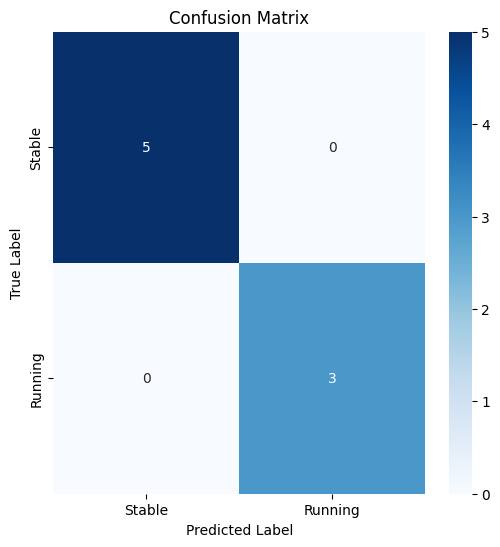

In [32]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

# 피치 변형 함수
def pitch_shift(audio, sample_rate, n_steps):
    # 올바른 순서로 인자 전달 (y=audio, sr=sample_rate, n_steps=n_steps)
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps)

# 시간 신속도 조정 함수
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)


# 데이터 증강 함수
def augment_data(audio, sample_rate):
    augmented_data = []
    augmented_data.append(audio)  # 원본 데이터 추가
    augmented_data.append(pitch_shift(audio, sample_rate, n_steps=2))  # +2피치
    augmented_data.append(pitch_shift(audio, sample_rate, n_steps=-2))  # -2피치
    augmented_data.append(time_stretch(audio, rate=1.2))  # 느리게
    augmented_data.append(time_stretch(audio, rate=0.8))  # 빠르게
    return augmented_data

# 오디오 파일에서 특징 추출 함수
def extract_features_from_audio(audio, sample_rate):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean


# 증강된 데이터 로드 함수
def load_and_augment(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    augmented_audios = augment_data(audio, sample_rate)
    return augmented_audios

# 데이터셋 로드 및 증강 함수
def load_data_with_augmentation(dataset_path):
    features = []
    labels = []

    stable_path = os.path.join(dataset_path, 'stable')
    for filename in os.listdir(stable_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(stable_path, filename)
            audio, sr = librosa.load(file_path, sr=None)  # 원본 파일 로드
            augmented_data = augment_data(audio, sr)
            for data in augmented_data:
                feature = extract_features_from_audio(data, sr)
                features.append(feature)
                labels.append(0)  # 안정된 상태 레이블은 0

    running_path = os.path.join(dataset_path, 'running')
    for filename in os.listdir(running_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(running_path, filename)
            audio, sr = librosa.load(file_path, sr=None)
            augmented_data = augment_data(audio, sr)
            for data in augmented_data:
                feature = extract_features_from_audio(data, sr)
                features.append(feature)
                labels.append(1)  # 중고강도 상태 레이블은 1

    return np.array(features), np.array(labels)


# 데이터 로딩 및 증강 적용
dataset_path = '/content/drive/MyDrive/dataset'
X, y = load_data_with_augmentation(dataset_path)

# 데이터셋 크기 출력
print(f'Original dataset size: 4 samples per class')
print(f'Augmented dataset size: {X.shape[0]} samples')

# 레이블을 one-hot 인코딩
y = to_categorical(y, num_classes=2)

# 데이터셋을 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # 두 가지 클래스를 예측

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 데이터 차원 맞추기 (LSTM에 맞게 입력 형태 변환)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
y_pred = model.predict(X_test)

# 모델 평가: 정확도, 정밀도, 재현율, F1-score
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# 혼동 행렬 출력
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stable", "Running"], yticklabels=["Stable", "Running"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# 1. 결과 분석
결과를 보면, 원본 데이터가 매우 적음에도 불구하고 증강을 통해 40개의 샘플로 확장하고, 모델 학습 후 검증 정확도와 평가 지표(Accuracy, Precision, Recall, F1-score)가 모두 1.0으로 나타납니다.



## a. 데이터셋 규모와 증강
**원본 데이터:** 클래스당 4개의 샘플

→ 극히 제한된 데이터로 인해 모델이 본질적인 패턴을 학습하기엔 데이터 부족 문제가 있음.

**증강 데이터:** 증강을 통해 전체 40개의 샘플로 확장

→ 증강된 데이터는 다양성을 어느 정도 제공할 수 있지만, 증강 기법이 원본의 한계를 극복할 만큼 충분한 다양성을 제공하는지는 재검토가 필요합니다.

## b. 학습 및 검증 결과
**초기 에포크:** 훈련 정확도는 65~75% 정도, 검증 정확도는 낮은 수치를 보이다가

**중후반 에포크:** 빠르게 100%에 도달하며, 손실(loss)이 거의 0에 가까워짐

**최종 결과:** 모든 지표가 1.0으로 나타남

이러한 완벽한 결과는 두 가지 가능성을 시사합니다:

**1. 과적합(Overfitting)**

증강된 데이터가 원본 데이터의 변형에 불과하므로, 모델이 사실상 동일한 패턴만 반복해서 학습할 수 있습니다.

작은 데이터셋에서 지나치게 높은 정확도가 나오면, 실제 다양한 상황에서는 일반화가 어려울 수 있습니다.

**2. 검증 데이터의 문제**

학습셋과 검증셋이 충분히 분리되지 않았거나, 증강 과정에서 데이터 누수가 발생할 가능성 등으로 인해 검증셋 자체가 모델이 학습한 패턴과 유사해진 경우입니다.



# 2. 결론
현재 결과는 매우 이상적이며 완벽한 수치를 보이지만, 데이터의 다양성과 양적인 한계로 인해 실제 환경에서의 일반화 성능은 불확실할 수 있습니다. 앞으로는

**더 많은 실제 데이터를 수집**하고,

**다양한 증강 기법과 모델 정규화** 및

**교차 검증**을 통해 모델의 신뢰성을 높이는 방향으로 연구를 진행하는 것이 좋겠습니다.



### 향후 연구 방향에 대한 조언

a. 데이터 측면 개선
원본 데이터 확보:
증강 기술은 어느 정도 도움이 되지만, 궁극적으로는 다양한 실제 상황에서의 원본 음성 데이터를 더 많이 확보하는 것이 필요합니다.

운동 상태와 평상시의 음성 데이터를 다양하게 수집하는 것이 중요합니다.

증강 기법 다양화:
현재는 피치 변형과 시간 신축(시간 왜곡)만 사용하고 있습니다.

배경 소음 추가, 리버브, 랜덤 노이즈 삽입 등 다양한 환경 변화를 모사할 수 있는 증강 기법을 도입해 보세요.

GAN(Generative Adversarial Networks) 기반 증강 방법 등 최근 기술을 참고할 수 있습니다.

b. 모델 측면 개선
모델 복잡도와 정규화:
– 데이터가 적은 상황에서는 모델의 복잡도를 줄이거나, 정규화(L2 정규화, 드롭아웃 등)를 강화하여 과적합을 방지하는 것이 필요합니다.

전이 학습(Transfer Learning):
– 이미 음성 분야에서 사전 학습된 모델(예: 오디오 CNN, transformer 기반 모델 등)을 fine-tuning 하는 방식으로 전이 학습을 고려해 보세요.

다양한 특성 추출 기법:
– MFCC 외에도 Mel Spectrogram, Chroma features 등 다양한 음성 특징을 추출해보고, 이들을 결합한 multi-modal 접근도 검토해 볼 수 있습니다.

c. 평가 및 검증 개선
K-Fold Cross Validation:
– 데이터셋이 작을 때는 단일 학습/검증 분할보다는 K-Fold 교차 검증을 통해 모델의 일반화 능력을 평가할 수 있습니다.

외부 테스트셋 구축:
– 모델이 실제 환경에서 어떻게 작동하는지 확인하기 위해, 별도의 테스트셋(실제 사용 환경에서 수집된 데이터)을 마련하여 평가하는 것이 좋습니다.

d. 추가 기능 및 연구 확장
다양한 센서 데이터 결합:
– 음성 데이터 외에도 심박수, 심전도, GPS, 음성 녹음 이외의 다양한 센서 데이터를 통합하여 운동 상태를 종합적으로 평가하는 멀티모달 모델 구축.

실시간 평가 및 사용자 피드백 적용:
– 앱 내에서 실시간으로 모델의 예측 결과를 사용자에게 피드백하고, 이를 통해 모델을 지속적으로 업데이트할 수 있는 시스템 구축.

